## Submit

## Импорт модулей и датасета

In [298]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, MinMaxScaler, FunctionTransformer, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()
from datetime import timedelta
import datetime as dt
import warnings
warnings.simplefilter("ignore")
%matplotlib inline
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.random.seed(42)
%config InlineBackend.figure_format = 'retina'

# sns.set(style='whitegrid', palette='deep')
# sns.set(style='darkgrid', palette='rocket')
sns.set(style='darkgrid', palette='deep')

plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'

In [110]:
target = 'source_attractiveness'
df_orig = pd.read_csv('train.csv', index_col=0)
df = df_orig.copy()
df.head()

,category,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,date_of_registration
6622,ecom,6488536.00000,NaN,0,82221,0,0,18.45053,0.46175,2020-04-21 16:04:41.817367072
2047,information_source,874840.00000,21100.00000,0,12872,0,0,10.72162,-0.02232,2024-07-19 23:50:07.268931816
1118,information_source,571210.00000,94707.00000,0,0,7420,0,1.92224,0.04640,2024-07-13 16:35:54.794883135
4992,news,89534.00000,924.00000,0,834,0,0,2.14924,-0.09336,2024-09-10 21:29:14.006315095
9970,information_source,1043953.00000,289288.00000,0,58375,20260,3948,3.76497,0.02730,2024-05-26 11:07:15.950527838


## Анализ

[Text(0.5, 0, 'source_attractiveness'), Text(0, 0.5, 'count')]

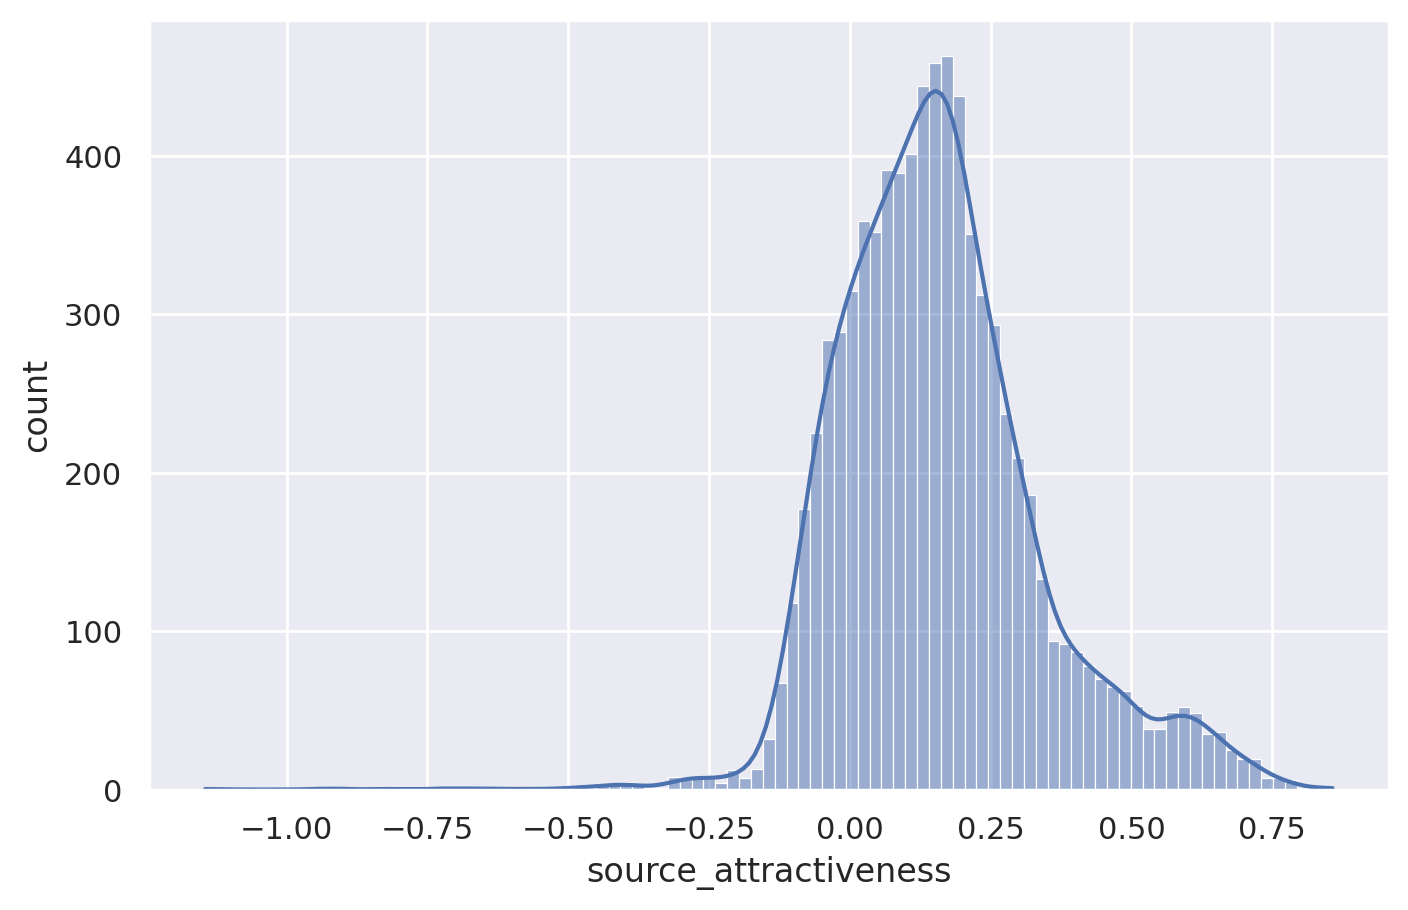

In [18]:
plot = sns.histplot(np.log1p(df[target].values), kde=True)
plot.set(xlabel=target, ylabel='count')

In [35]:
df.dtypes

category                  object
clicks                   float64
likes                    float64
buys                       int64
4xx_errors                 int64
5xx_errors                 int64
complaints_count          object
average_dwelltime        float64
source_attractiveness    float64
date_of_registration      object
dtype: object

In [63]:
df.category.unique()

array(['ecom', 'information_source', 'news', 'porn', 'social'],
      dtype=object)

In [39]:
df.describe()

,clicks,likes,buys,4xx_errors,5xx_errors,average_dwelltime,source_attractiveness
count,7727.00000,7624.00000,8000.00000,8000.00000,8000.00000,8000.00000,8000.00000
mean,2749784.60826,598502.74318,581050.94688,82049.57962,27692.24125,6.97955,0.19200
std,4699119.93978,1978345.31783,2262221.35719,155521.90818,79469.34824,10.00492,0.22787
min,51.00000,0.00000,0.00000,0.00000,0.00000,-1.00000,-0.68172
25%,359921.00000,0.00000,0.00000,2943.00000,0.00000,1.50393,0.03822
50%,1097221.00000,33995.50000,0.00000,26717.50000,0.00000,4.02280,0.15426
75%,2915358.00000,286063.75000,0.00000,95002.25000,20163.75000,8.89940,0.28251
max,62032065.00000,55821812.00000,42773913.00000,2904996.00000,1865588.00000,211.21807,1.35574


In [206]:
dataset = df.copy()
dataset.complaints_count = dataset.complaints_count.replace('-', np.NAN)
dataset.average_dwelltime = dataset.average_dwelltime.replace(-1, np.NAN)
dataset = dataset.dropna()

Первое, что мы можем заметить это то, что колонки *clicks* и *likes* представлены нецелочисленным типом данных. *date_of_registration* и *complaints_count* представлены строкой. Исправим

In [133]:
def preprocess_data_time_num(df):
    data = df.copy()
    data.category = data.category.fillna('other')
    data.complaints_count = data.complaints_count.replace('-', np.NAN)
    data.average_dwelltime = data.average_dwelltime.replace(-1, np.NAN)
    data.category = data.category.astype(dtype="category")
    data.complaints_count = data.complaints_count.astype(dtype="Int64")
    data.clicks = data.clicks.astype(dtype="Int64")
    data.date_of_registration = pd.to_datetime(data.date_of_registration)
    data.likes = data.likes.astype(dtype="Int64")
    data['year'] =  data.date_of_registration.dt.year
    data['second'] =  data.date_of_registration.dt.second
    data['minute'] =  data.date_of_registration.dt.minute
    data['hour'] =  data.date_of_registration.dt.hour
    data['weekday'] = (data.date_of_registration.dt.weekday + 1)
    data['month'] = data.date_of_registration.dt.month
    data['day'] = data.date_of_registration.dt.day
    data['day_of_year'] =  data.date_of_registration.dt.dayofyear
    data = data.drop(columns=['date_of_registration'])
    return data

def preprocess_data_time_cat(df):
    data = df.copy()
    data.category = data.category.fillna('other')
    data.complaints_count = data.complaints_count.replace('-', np.NAN)
    data.average_dwelltime = data.average_dwelltime.replace(-1, np.NAN)
    data.category = data.category.astype(dtype="category")
    data.complaints_count = data.complaints_count.astype(dtype="Int64")
    data.clicks = data.clicks.astype(dtype="Int64")
    data.date_of_registration = pd.to_datetime(data.date_of_registration)
    data.likes = data.likes.astype(dtype="Int64")
    data['year'] =  data.date_of_registration.dt.year.astype(dtype="category")
    data['second'] =  data.date_of_registration.dt.second.astype(dtype="category")
    data['minute'] =  data.date_of_registration.dt.minute.astype(dtype="category")
    data['hour'] =  data.date_of_registration.dt.hour.astype(dtype="category")
    data['weekday'] = (data.date_of_registration.dt.weekday + 1).astype(dtype="category")
    data['month'] = data.date_of_registration.dt.month.astype(dtype="category")
    data['day'] = data.date_of_registration.dt.day.astype(dtype="category")
    data['day_of_year'] =  data.date_of_registration.dt.dayofyear.astype(dtype="category")
    data = data.drop(columns=['date_of_registration'])
    return data


dataset = preprocess_data_time_num(df)
dataset.dtypes

category                 category
clicks                      Int64
likes                       Int64
buys                        int64
4xx_errors                  int64
5xx_errors                  int64
complaints_count            Int64
average_dwelltime         float64
source_attractiveness     float64
year                        int32
second                      int32
minute                      int32
hour                        int32
weekday                     int32
month                       int32
day                         int32
day_of_year                 int32
dtype: object

In [73]:
dataset.isna().sum()

category                 0
clicks                   0
likes                    0
buys                     0
4xx_errors               0
5xx_errors               0
complaints_count         0
average_dwelltime        0
source_attractiveness    0
second                   0
minute                   0
hour                     0
weekday                  0
month                    0
day                      0
day_of_year              0
dtype: int64

array([[<Axes: title={'center': 'clicks'}>,
        <Axes: title={'center': 'likes'}>,
        <Axes: title={'center': 'buys'}>,
        <Axes: title={'center': '4xx_errors'}>],
       [<Axes: title={'center': '5xx_errors'}>,
        <Axes: title={'center': 'complaints_count'}>,
        <Axes: title={'center': 'average_dwelltime'}>,
        <Axes: title={'center': 'source_attractiveness'}>],
       [<Axes: title={'center': 'second'}>,
        <Axes: title={'center': 'minute'}>,
        <Axes: title={'center': 'hour'}>,
        <Axes: title={'center': 'weekday'}>],
       [<Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'day_of_year'}>, <Axes: >]], dtype=object)

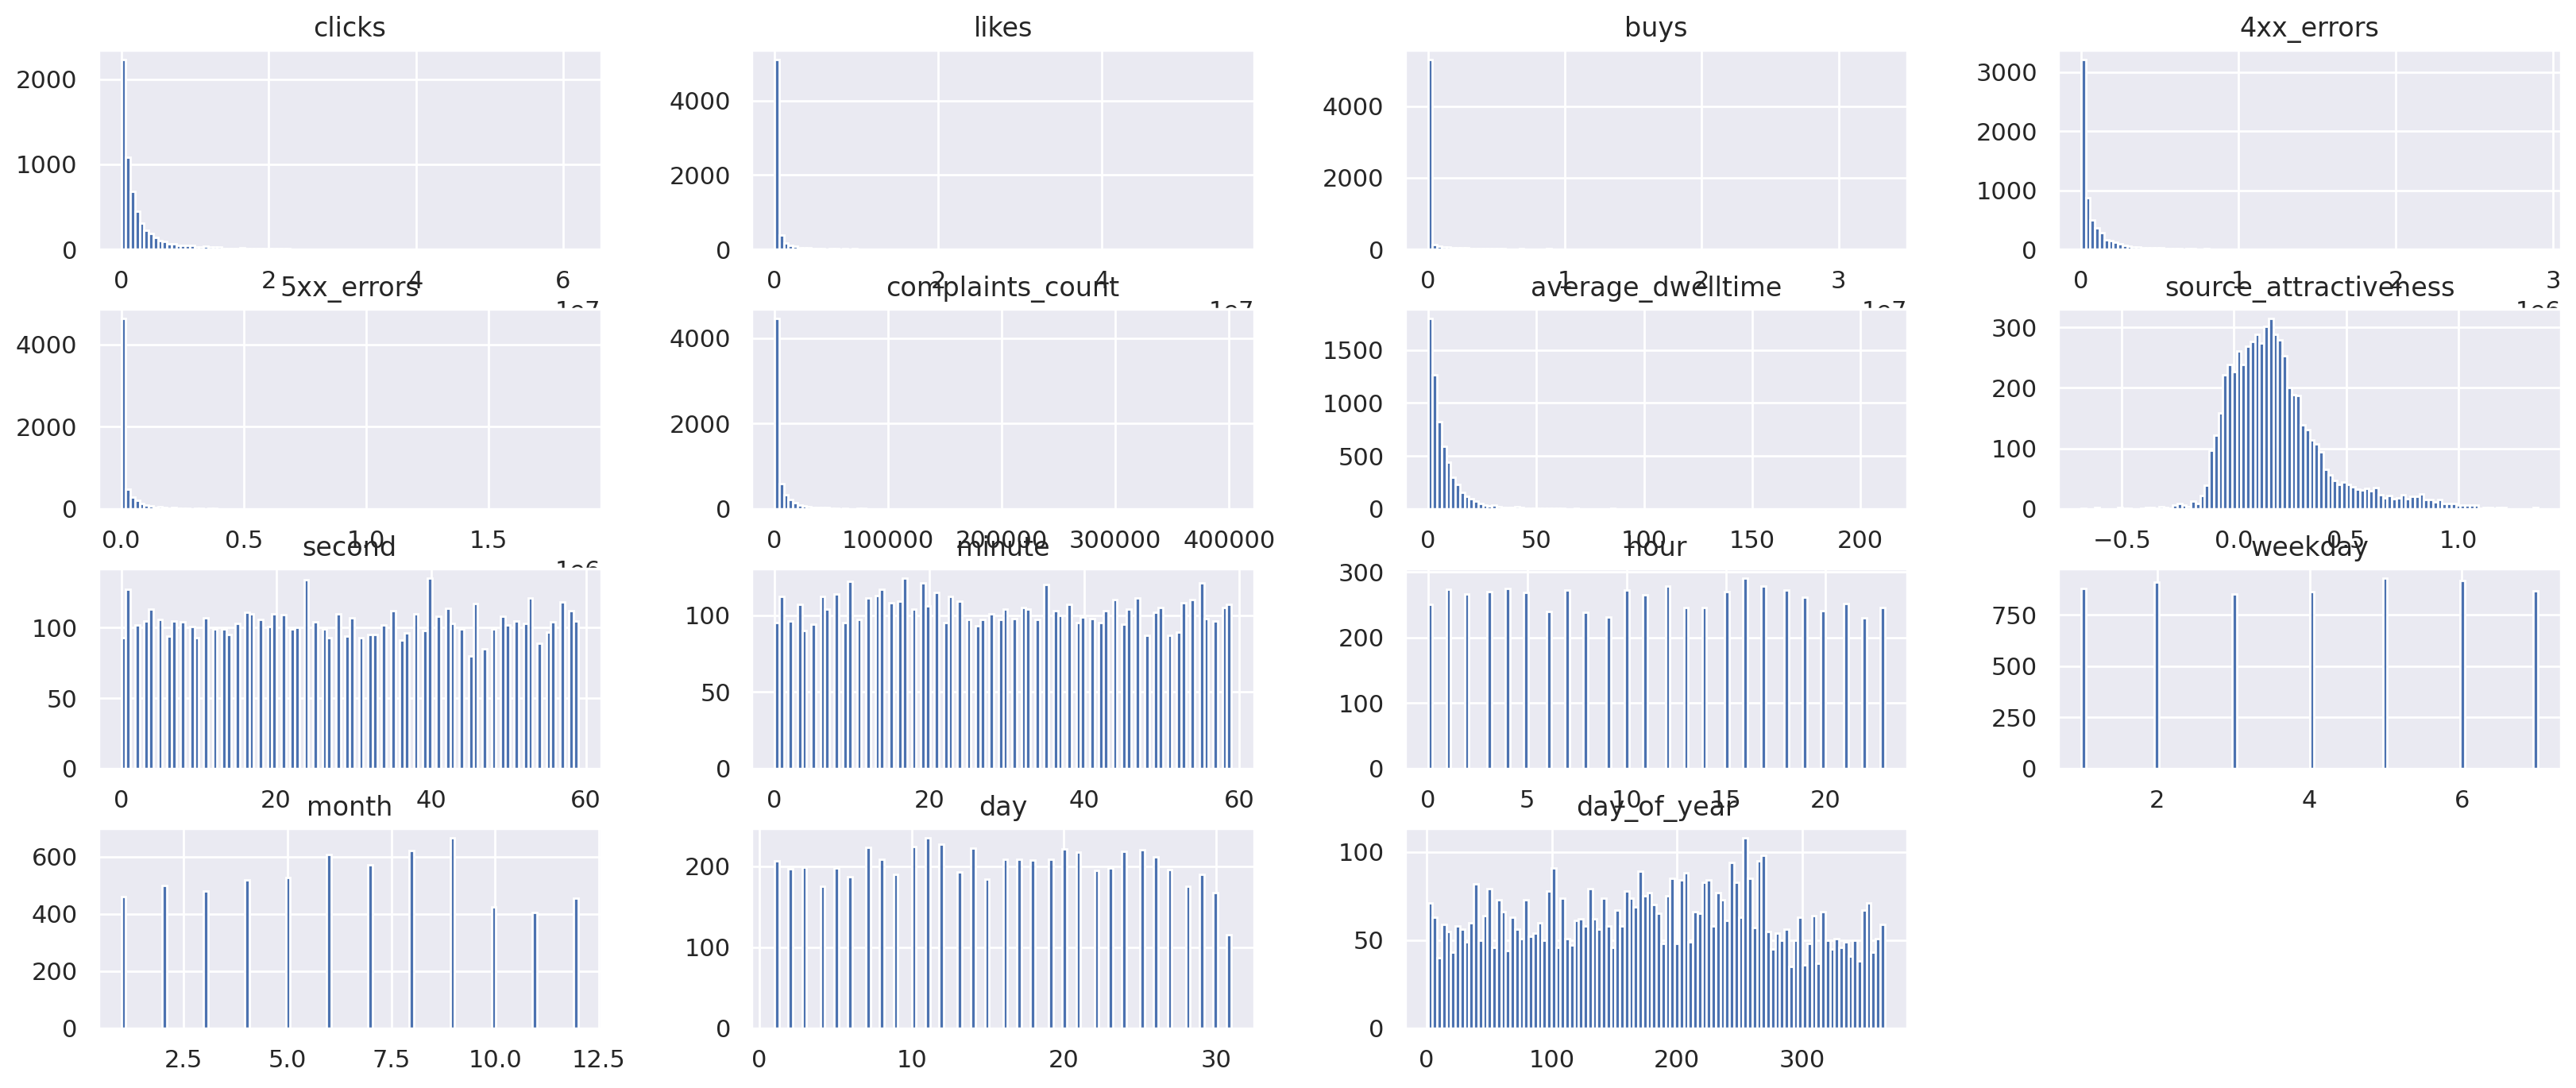

In [75]:
dataset.hist(bins=100, figsize=(20,8))

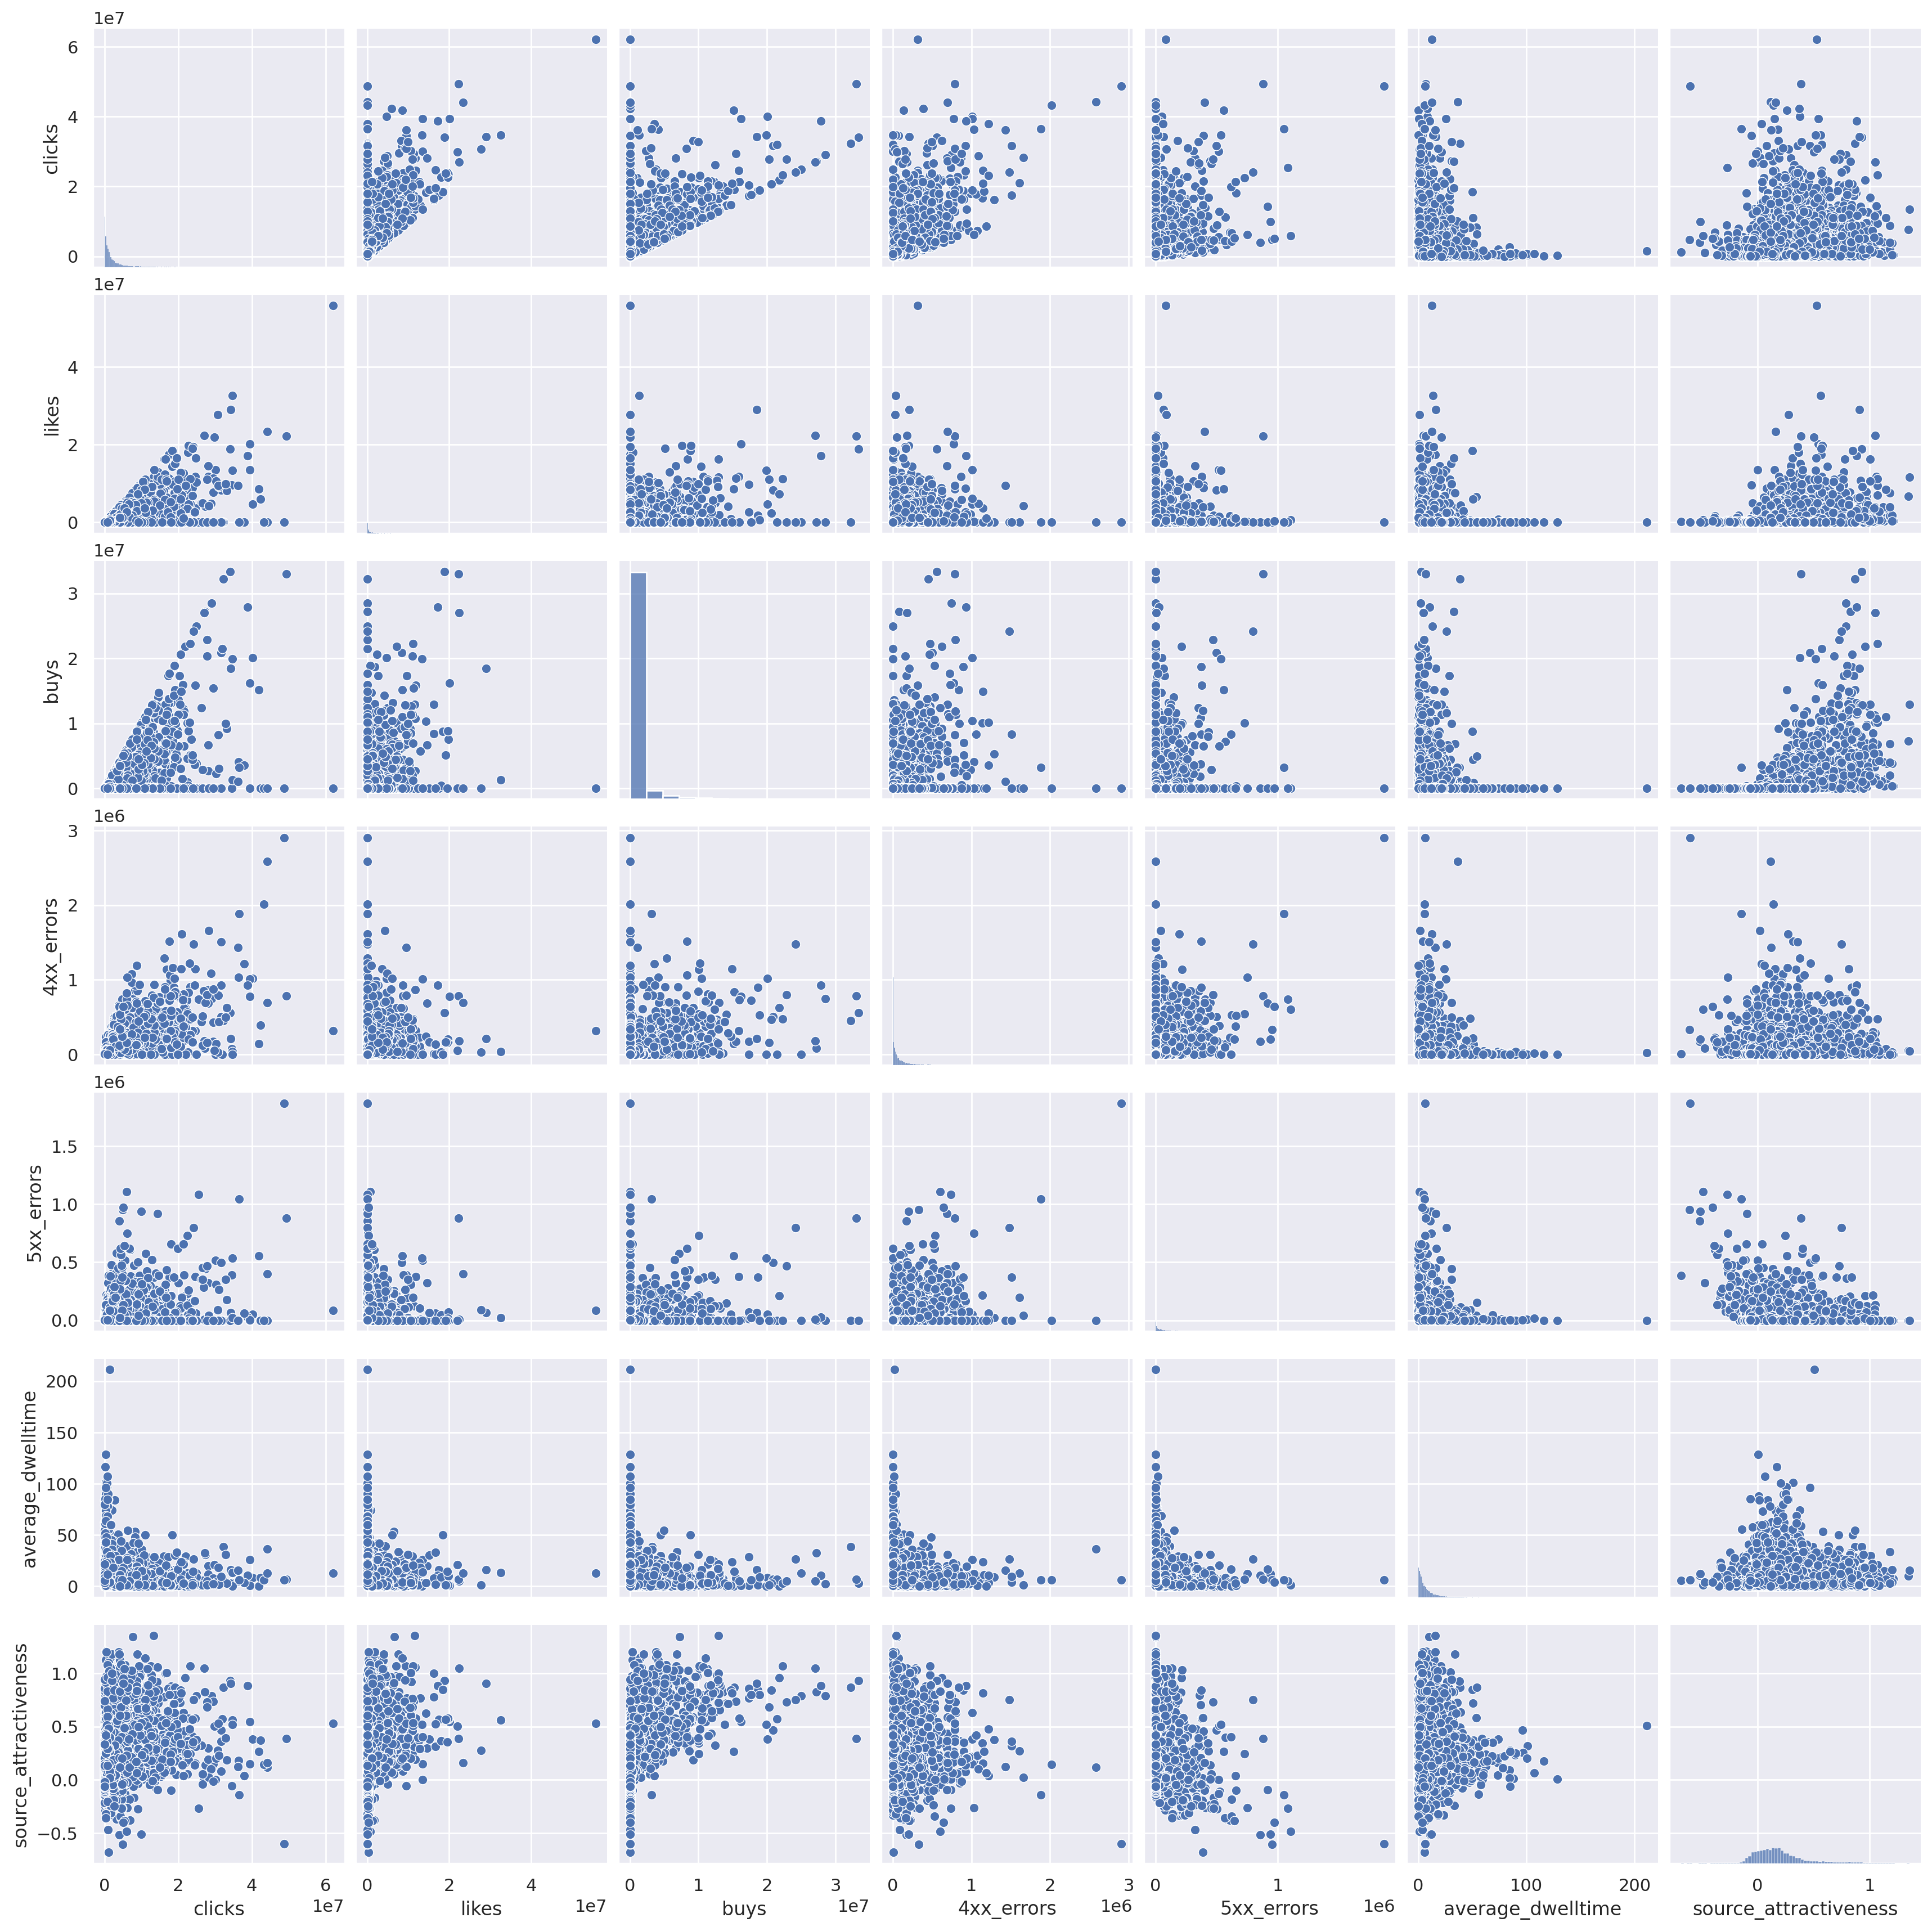

In [326]:
sns.pairplot(dataset)

## Разделение на обучающую и тестовую выборки

In [305]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns=[target]), dataset[target], test_size=0.2, random_state=42, stratify=dataset.category)

preprocessor = FunctionTransformer(preprocess_data_time_cat)

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)
columnTransformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selector(dtype_exclude="category")),
        ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist'), selector(dtype_include="category"))
    ], n_jobs=-1)

# regressor = ElasticNet(alpha=0.5, l1_ratio=0.5, warm_start=True, random_state=42)
regressor = Ridge()
lr_pipeline = Pipeline(steps=[ 
        ('preprocessor', preprocessor),
        ('columnTransformer', columnTransformer),
        ('regressor', regressor)
], verbose=True)

grid_search = GridSearchCV(cv=3, estimator=lr_pipeline,
             param_grid={'regressor__alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error', refit=True, n_jobs=-1,
             verbose=1)


grid_search.fit(X_train, y_train)

r2_score(y_test, grid_search.predict(X_test))

Fitting 3 folds for each of 28 candidates, totalling 84 fits
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.0s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.0s
[Pipeline] . (step 2 of 3) Processing columnTransformer, total=   0.1s
[Pipeline] . (step 2 of 3) Processing columnTransformer, total=   0.1s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.0s
[Pipeline] . (step 2 of 3) Processing columnTransformer, total=   0.1s
[Pipeline] . (step 2 of 3) Processing columnTransformer, total=   0.1s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.1s
[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.1s
[Pipeline] .....

0.7407368601487716

## Final model submit function

Принимает на вход путь к набору данных в формате `.csv`

На выходе получается файл с предиктами в формате `.csv`

Пример содержания:
```
0.432
0.412
0.312
```

Реализация модели - между ними

In [244]:
def predict(data_path):
    data = pd.read_csv(data_path)
    predicts = lr_pipeline.predict(data)
    with open('output.csv', 'w') as file:
        for predict in predicts:
            file.write(str(predict) + '\n')